In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

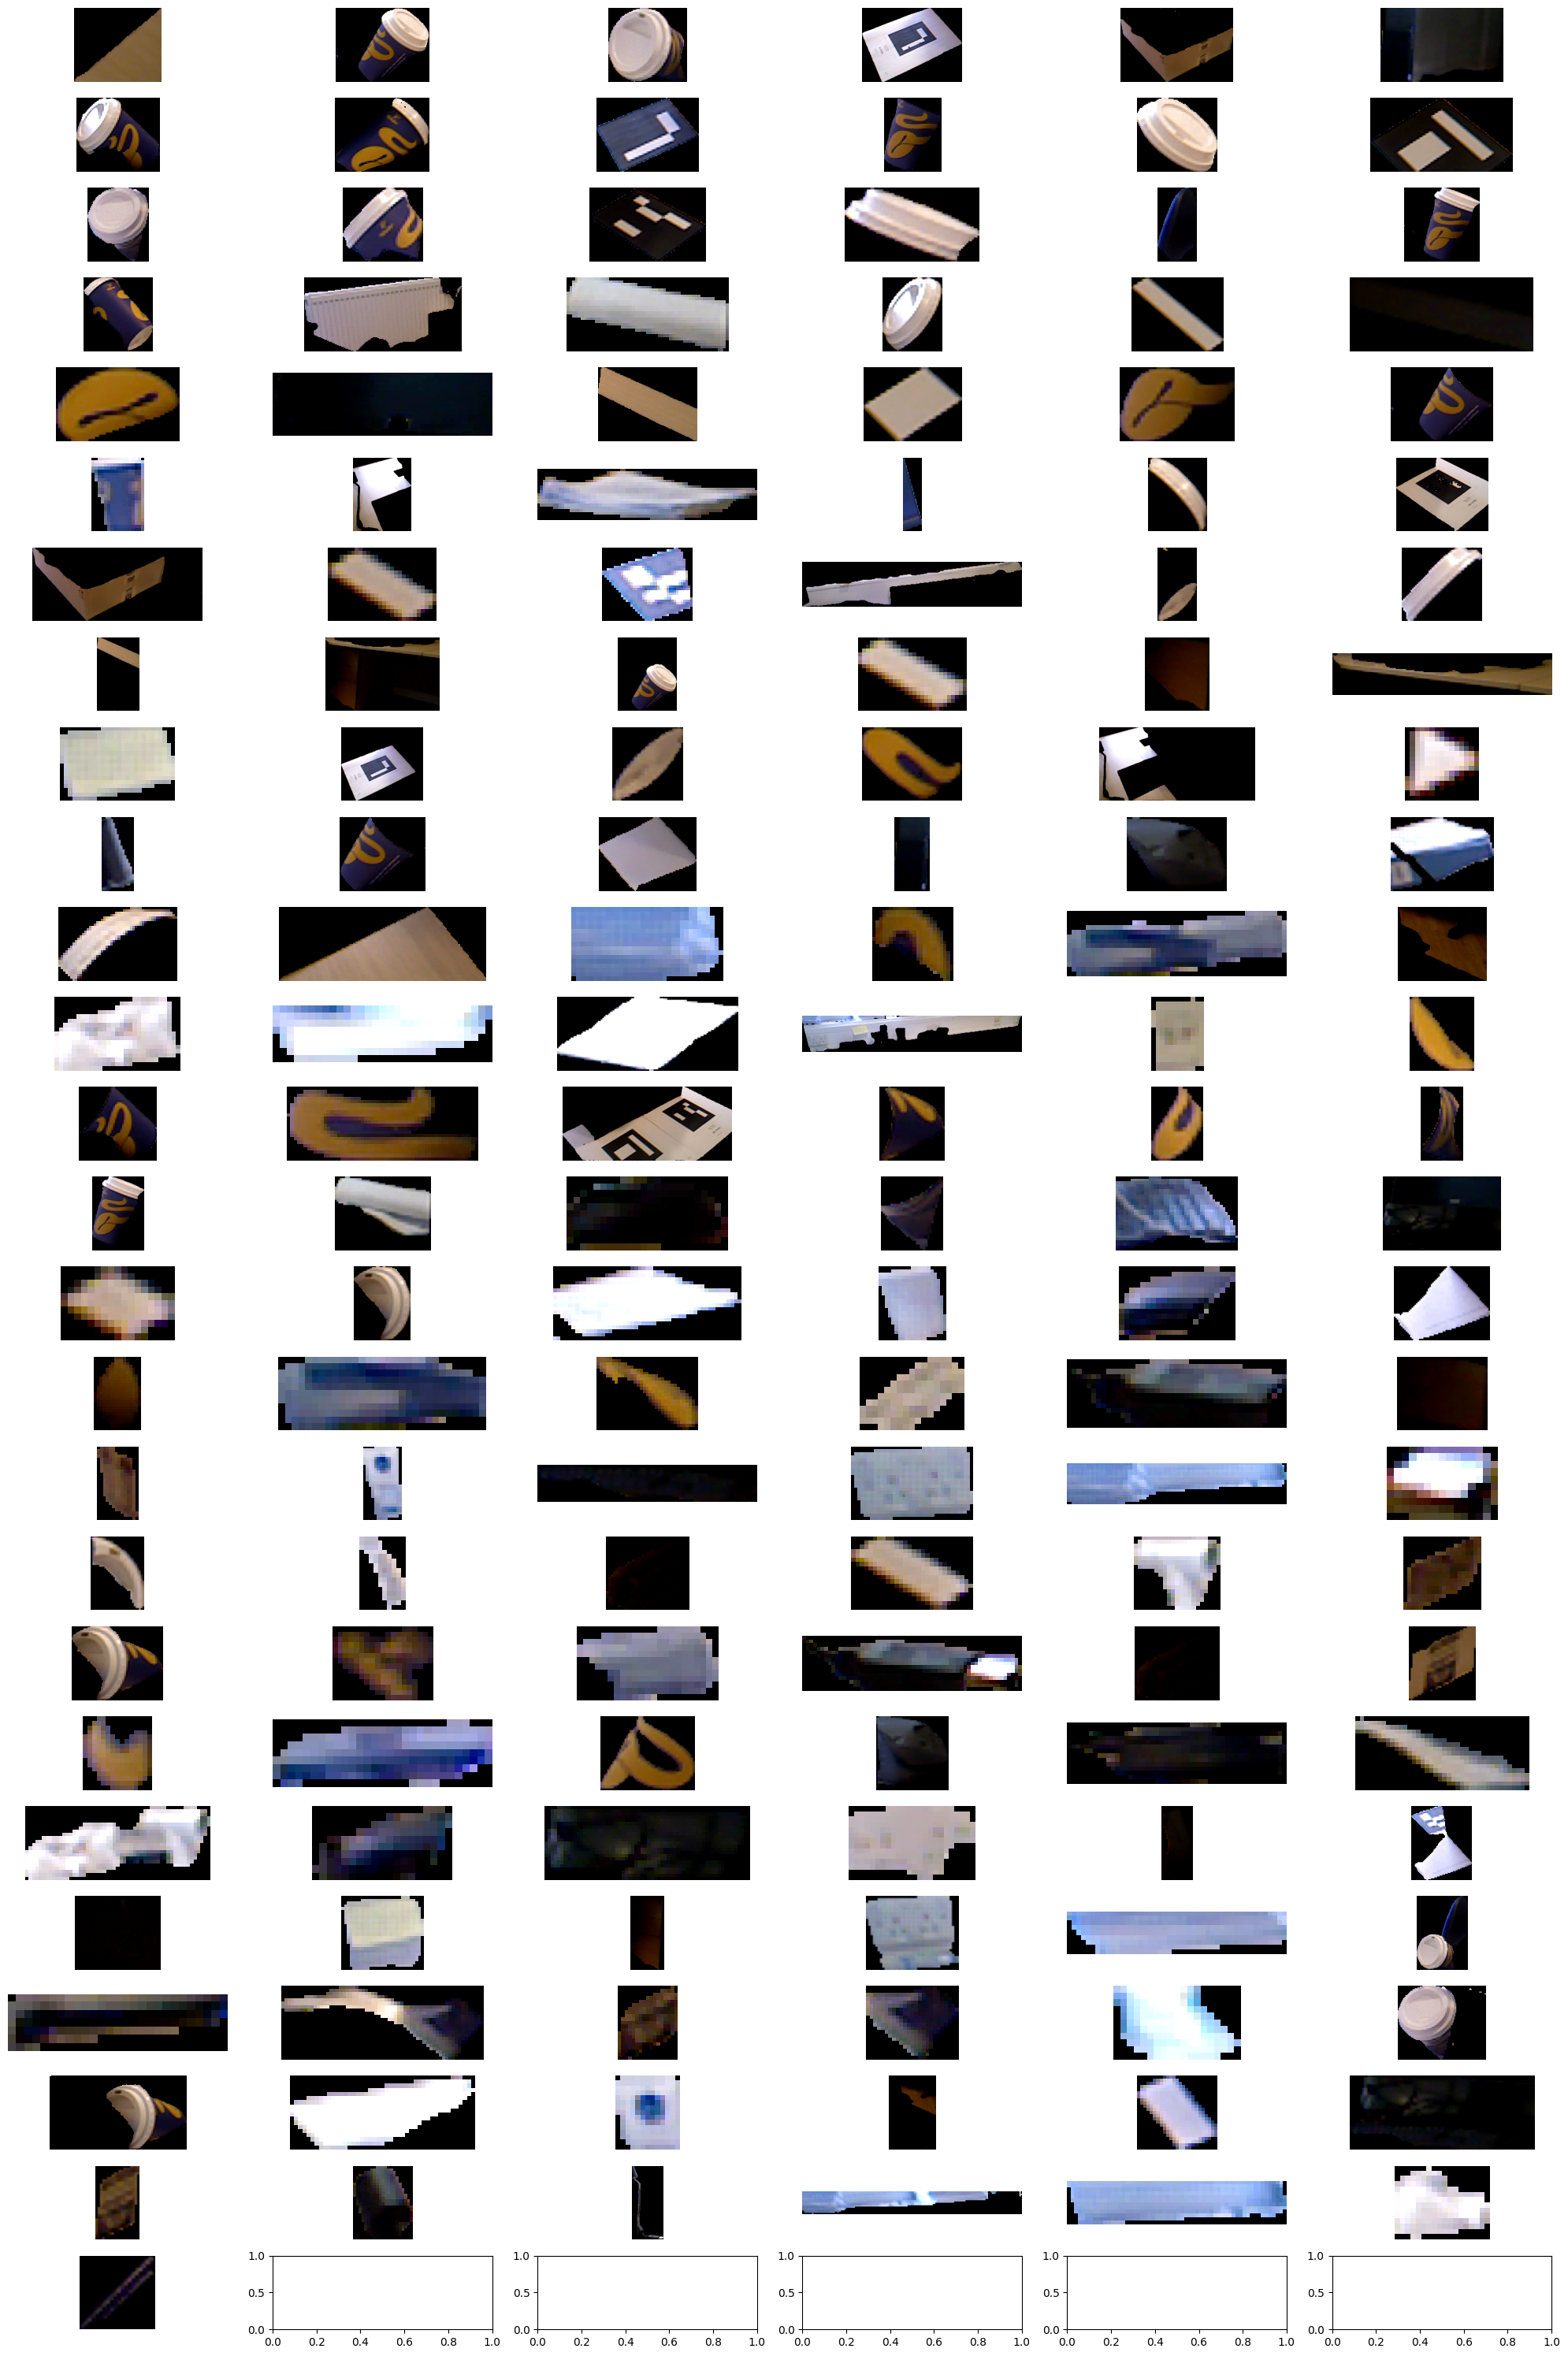

In [6]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

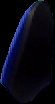

In [7]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 16 # 125, 102 for background; 2 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [8]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_4080281/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [9]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [10]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [11]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [12]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [13]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

324

In [14]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

324

In [15]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

1284

In [16]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [18]:
from src.model.foundpose import resize_and_pad_image
import torchvision.transforms as T

def original_cnos_templates_feature_extraction(templates, dino_model, num_templates, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_templates = [rgb_normalize(template/255.0).float() for template in templates]
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)
    print("normalized_templates shape", normalized_templates[0].shape)

    scaled_padded_templates = [resize_and_pad_image(normalized_template, target_max=224)
                            for normalized_template in normalized_templates] # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_templates.shape", len(scaled_padded_templates), scaled_padded_templates[0].shape) 

    
    plt.imshow(templates[0]) #, cmap=plt.cm.gray)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    batch_size = 16
    layers_list = list(range(24))
    template_batches = [scaled_padded_templates[i:i+batch_size] for i in range(0, len(scaled_padded_templates), batch_size)]
    patch_features= list()

    for batch in template_batches:
        batch = torch.stack(batch)
        size = batch.shape[0]
        torch.cuda.empty_cache()
        with torch.no_grad(): 
            batch_feature = dino_model.module.get_intermediate_layers(
                batch.to(device), n=layers_list, return_class_token=True
                )[18][1].reshape(size,-1,1024).cpu()
        patch_features.append(batch_feature.to('cpu'))
        del batch_feature
    patch_features = torch.cat(patch_features)
    del dino_model

    return patch_features.squeeze().to("cuda:0")

In [19]:
from sklearn.decomposition import PCA
def cnos_templates_feature_extraction(templates, dino_model, num_templates, device):
    ''' 
    Extract features at layer 18th - size 30*30,1024
    Apply PCA to reduce size to 30*30*3 only ( can test with different size)
    Flatten the tensor to 2700
    '''

    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_templates = [rgb_normalize(template/255.0).float() for template in templates]
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)
    print("normalized_templates shape", normalized_templates[0].shape)

    scaled_padded_templates = [resize_and_pad_image(normalized_template, target_max=420)
                            for normalized_template in normalized_templates] # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_templates.shape", len(scaled_padded_templates), scaled_padded_templates[0].shape) 

    
    plt.imshow(templates[0]) #, cmap=plt.cm.gray)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    batch_size = 16
    layers_list = list(range(24))
    template_batches = [scaled_padded_templates[i:i+batch_size] for i in range(0, len(scaled_padded_templates), batch_size)]
    patch_features= list()

    for batch in template_batches:
        batch = torch.stack(batch)
        size = batch.shape[0]
        torch.cuda.empty_cache()
        with torch.no_grad(): 
            batch_feature = dino_model.module.get_intermediate_layers(
                batch.to(device), n=layers_list, return_class_token=True
                )[18][0].reshape(size,-1,1024).cpu() 
        patch_features.append(batch_feature.to('cpu'))
        del batch_feature
    patch_features = torch.cat(patch_features)
    del dino_model

    # PCA
    pca = PCA(n_components=3)
    pca_patches_descriptors = [pca.fit_transform(np.array(patch_feature)).flatten() for patch_feature in patch_features]

    return torch.tensor(pca_patches_descriptors)# patch_features.squeeze().to("cuda:0")

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 420, 420])


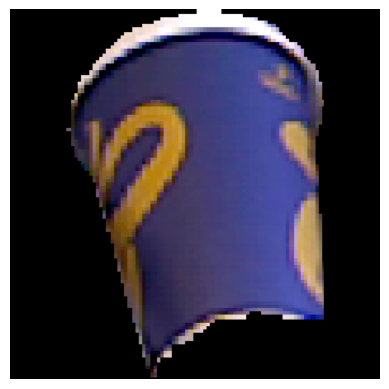

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [20]:
real_ref_features = cnos_templates_feature_extraction(
    templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
    )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
pyrender_ref_features = cnos_templates_feature_extraction(
    templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
    )

In [ ]:
pyrender_ref_features.shape

torch.Size([1284, 2700])

# 3. Extract features from crop and compare with templates

In [ ]:
def original_cnos_crop_feature_extraction(crop_rgb, dino_model, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_crop_rgb = rgb_normalize(crop_rgb/255.0).float()
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)

    scaled_padded_crop_rgb = resize_and_pad_image(normalized_crop_rgb, target_max=224).unsqueeze(0) # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape)


    # Extract features from 18th layer of Dinov2 
    layers_list = list(range(24))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dino_model.module.get_intermediate_layers(
            scaled_padded_crop_rgb.to(device), n=layers_list, return_class_token=True)[18][1].reshape(-1,1024)
    del dino_model

    return feature_patches

In [ ]:
def cnos_crop_feature_extraction(crop_rgb, dino_model, device):
    ''' 
    resize input to 420*420
    Extract features at layer 18th - size 30*30,1024
    Apply PCA to reduce size to 30*30*3 only ( can test with different size)
    Flatten the tensor to 2700
    '''
    
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_crop_rgb = rgb_normalize(crop_rgb/255.0).float()
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)

    scaled_padded_crop_rgb = resize_and_pad_image(normalized_crop_rgb, target_max=420).unsqueeze(0) # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape)


    # Extract features from 18th layer of Dinov2 
    layers_list = list(range(24))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dino_model.module.get_intermediate_layers(
            scaled_padded_crop_rgb.to(device), n=layers_list, return_class_token=True)[18][0].reshape(-1,1024).to("cpu")
    del dino_model

    # PCA
    pca = PCA(n_components=3)
    pca_patches_descriptors = pca.fit_transform(np.array(feature_patches)).flatten()

    return torch.tensor(pca_patches_descriptors).unsqueeze(0) # patch_features.squeeze().to("cuda:0")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
import math
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features,templates, metric = metric):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(score_per_detection, dim=-1) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    # Round up to two decimal places
    rounded_scores = [math.ceil(score * 1000) / 1000 for score in similar_scores[0]]
    rounded_avg_score = math.ceil(score_per_detection.item() * 1000) / 1000

    width = 50
    height = 50
    fig = plt.figure(figsize=(7, 7))
    columns = 3
    rows = 2

    for i, index in enumerate(similar_template_indices[0]):
        fig.add_subplot(rows, columns, i + 1)
        img = templates[index] # permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Template {index}')

    plt.tight_layout()
    plt.show()

    # Print the results
    print("Top 5 scores:", rounded_scores)
    print("Average score:", rounded_avg_score)


    return

## 3.1 Normal crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


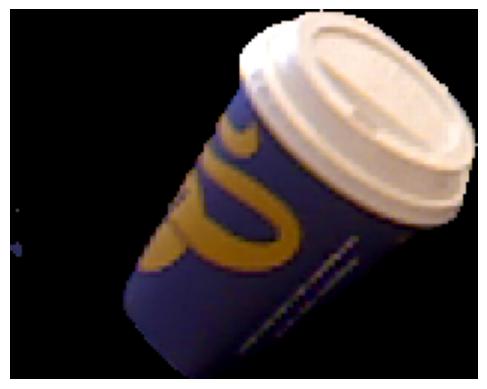

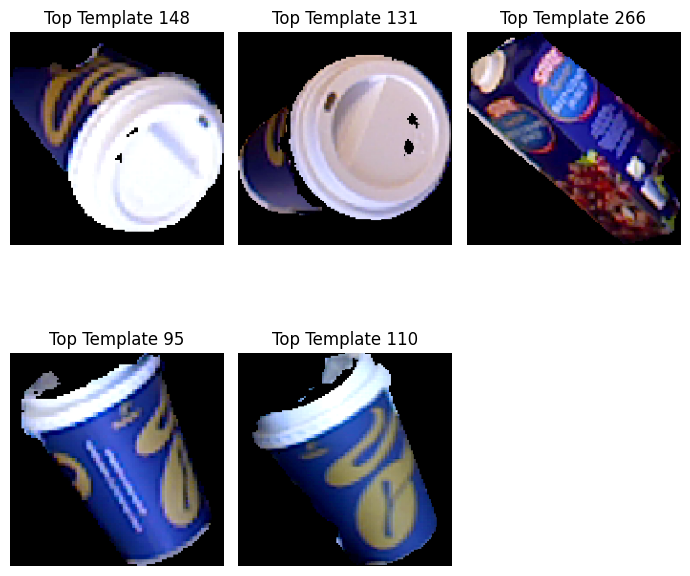

Top 5 scores: [0.786, 0.755, 0.742, 0.714, 0.702]
Average score: 0.74


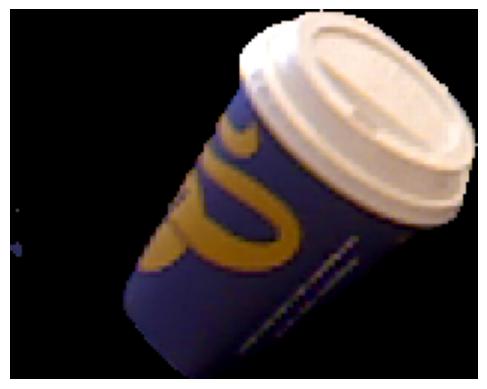

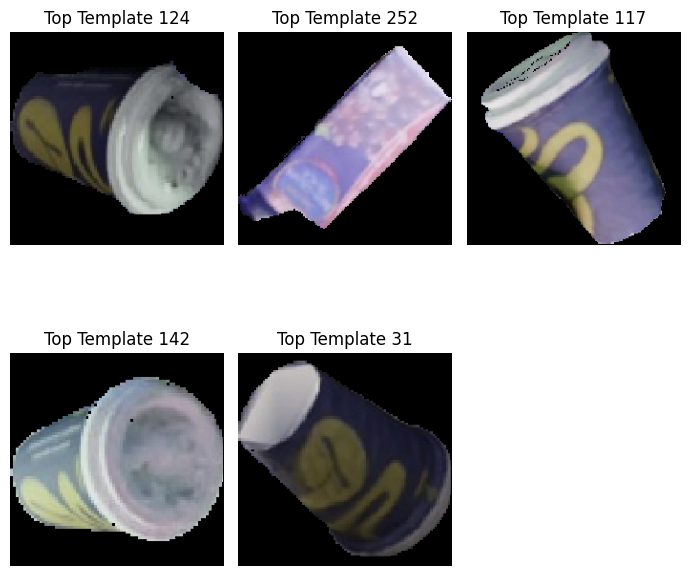

Top 5 scores: [0.846, 0.735, 0.715, 0.711, 0.706]
Average score: 0.742


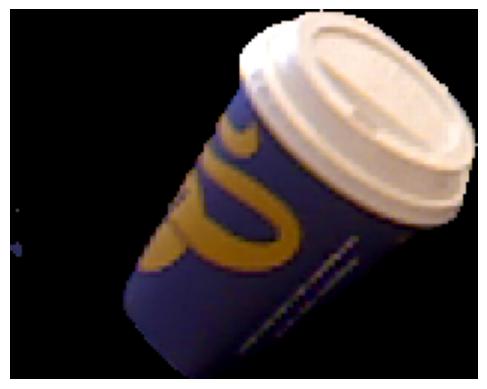

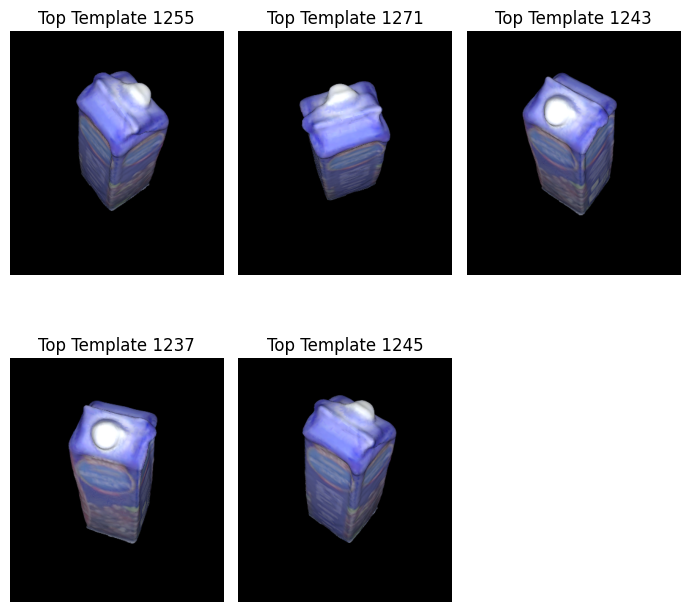

Top 5 scores: [0.617, 0.578, 0.574, 0.573, 0.564]
Average score: 0.581


In [ ]:
# normal crop
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
normal_features = cnos_crop_feature_extraction(crop_rgb, dinov2_vitl14, device)
calculate_similarity(crop_rgb, normal_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb, normal_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb, normal_features, pyrender_ref_features, pyrender_templates)

## 3.2 Zoomed crop

In [ ]:
from scipy.ndimage import zoom
def zoom_in(image, scale):
    return zoom(image, (scale, scale, 1))[image.shape[0]:,image.shape[1]:,:]

def zoom_out(image, scale):
    zoomed_out_image =  zoom(image, (1/scale, 1/scale, 1))
    # print(np.min(zoomed_out_image))
    background = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    background[image.shape[0]//2:zoomed_out_image.shape[0]+image.shape[0]//2, image.shape[0]//2:zoomed_out_image.shape[1]
        +image.shape[0]//2,:] = zoomed_out_image
    # print(np.min(background))
    # Clip values to be in the valid range [0, 255] and convert back to uint8
    background = background.astype("uint8")
    return background

crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
zoom_scale = 3  # Zoom in by a factor of 2
crop_rgb_zoomed_in = zoom_in(crop_rgb, zoom_scale)
crop_rgb_zoomed_out = zoom_out(crop_rgb, scale=2)

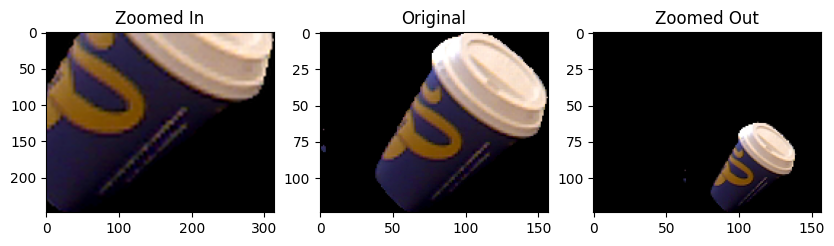

In [ ]:
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"Zoomed In")
plt.imshow(crop_rgb_zoomed_in)

plt.subplot(1, 3, 2)
plt.title(f"Original")
plt.imshow(crop_rgb)

plt.subplot(1, 3, 3)
plt.title(f"Zoomed Out")
plt.imshow(crop_rgb_zoomed_out)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


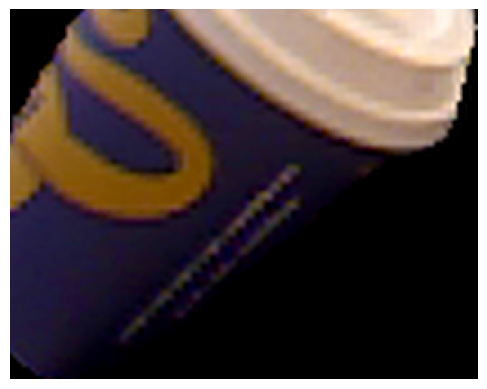

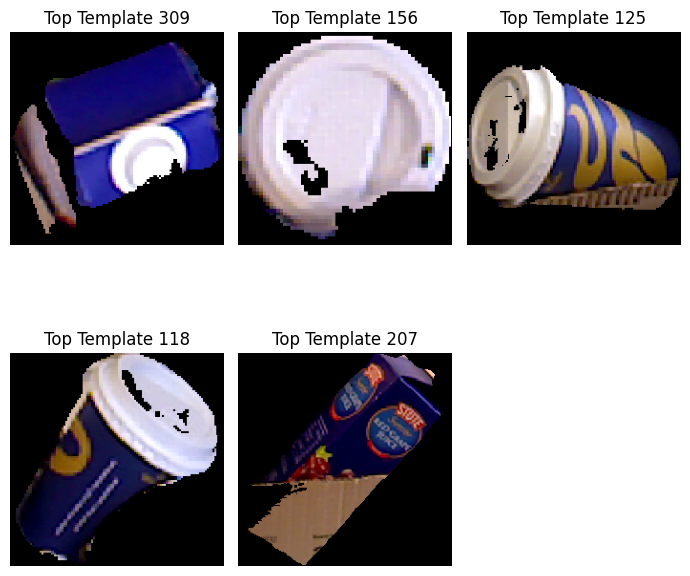

Top 5 scores: [0.783, 0.76, 0.715, 0.702, 0.688]
Average score: 0.73


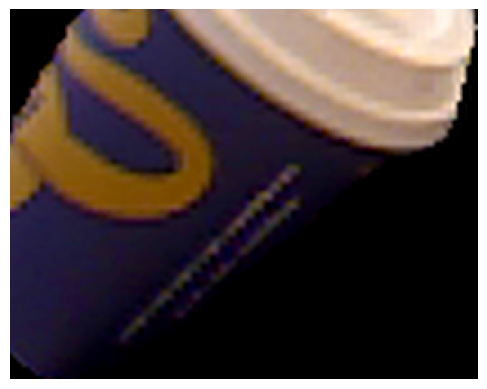

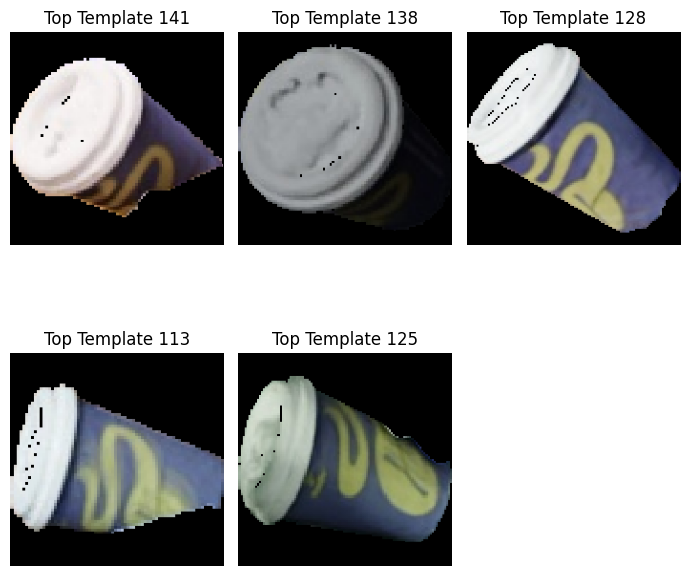

Top 5 scores: [0.77, 0.698, 0.672, 0.659, 0.652]
Average score: 0.69


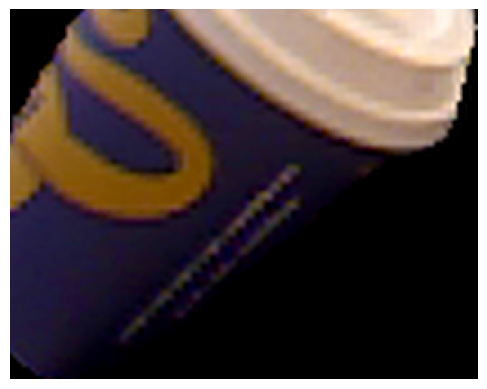

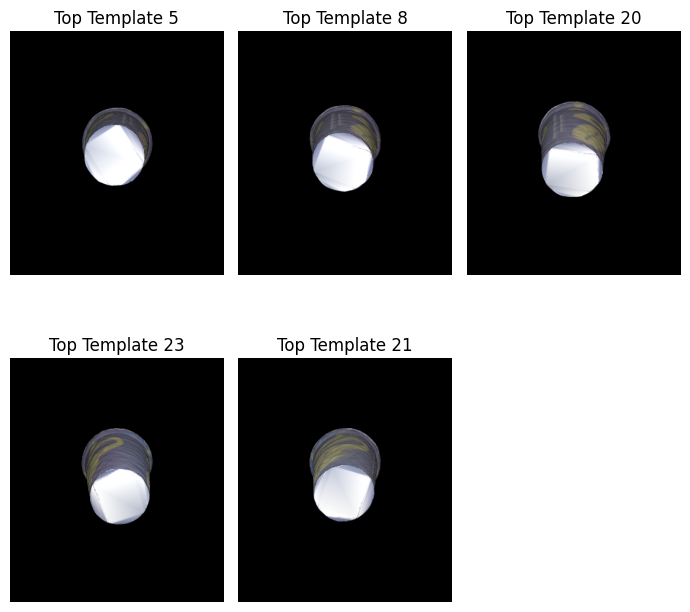

Top 5 scores: [0.642, 0.636, 0.634, 0.634, 0.634]
Average score: 0.636
Cosine similarity to the original crop tensor([[0.]])


In [ ]:
# Zoomed-in crop
zoom_in_features = cnos_crop_feature_extraction(crop_rgb_zoomed_in, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
zoom_in_scores = metric(normal_features[:, None, :], zoom_in_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
print("Cosine similarity to the original crop", zoom_in_scores)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


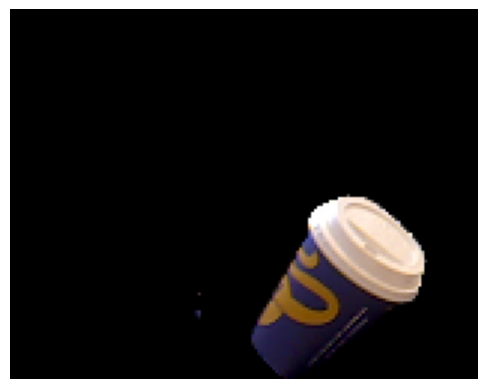

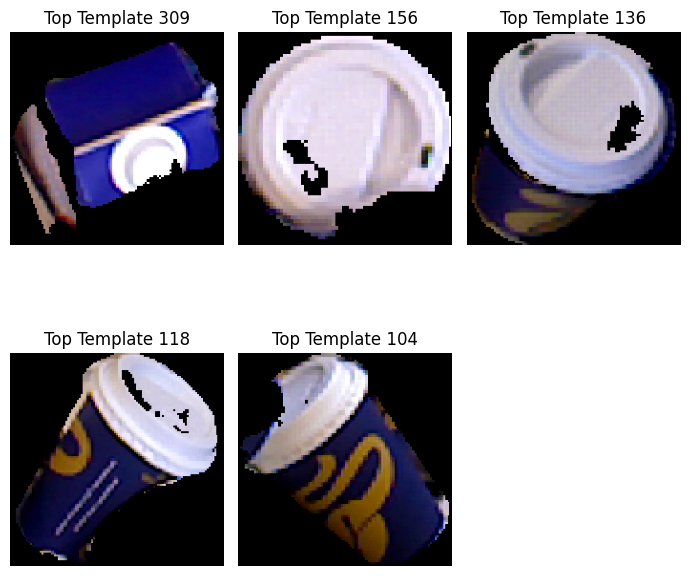

Top 5 scores: [0.853, 0.831, 0.755, 0.736, 0.593]
Average score: 0.754


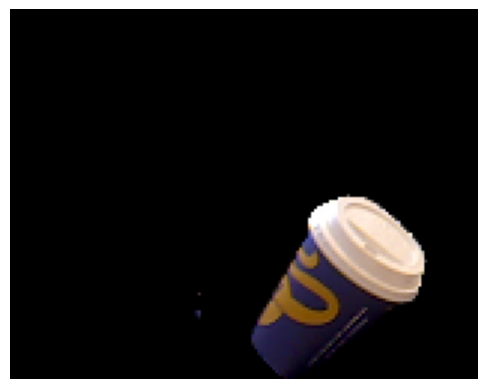

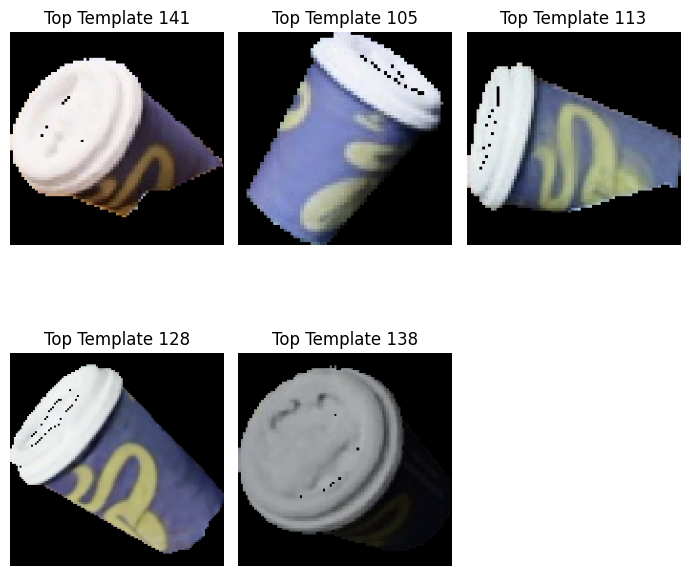

Top 5 scores: [0.64, 0.518, 0.515, 0.511, 0.509]
Average score: 0.539


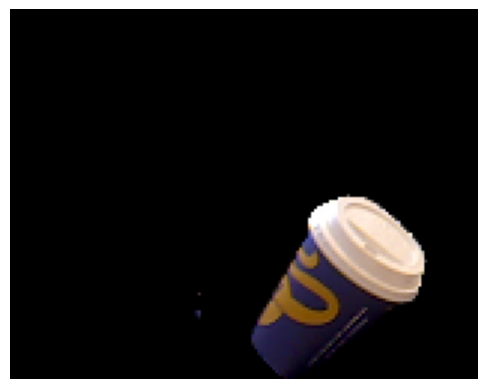

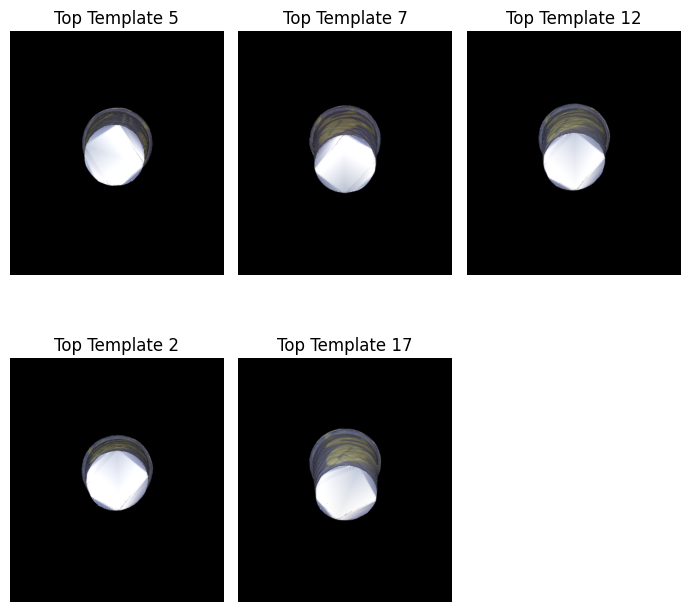

Top 5 scores: [0.644, 0.629, 0.627, 0.625, 0.623]
Average score: 0.63
Cosine similarity to the original crop tensor([[0.]])


In [ ]:
# Zoomed-out crop
zoom_out_features = cnos_crop_feature_extraction(crop_rgb_zoomed_out, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_45_crop
zoom_out_scores = metric(normal_features[:, None, :], zoom_out_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
print("Cosine similarity to the original crop", zoom_out_scores)

## 3.3 In-plane rotated crop

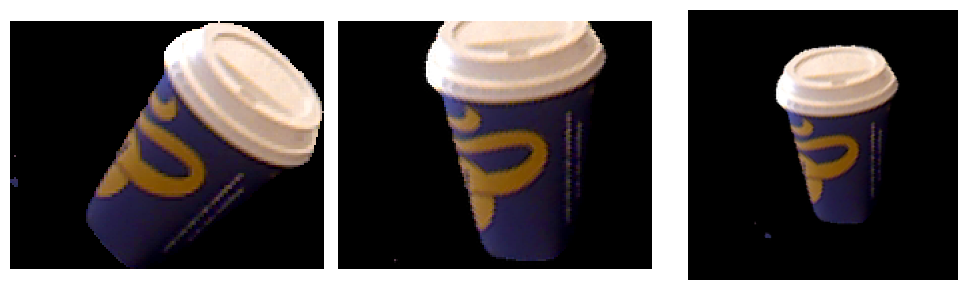

In [ ]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = crop_rgb
img_45 = ndimage.rotate(img, 45, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


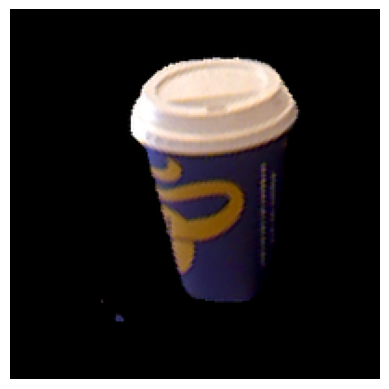

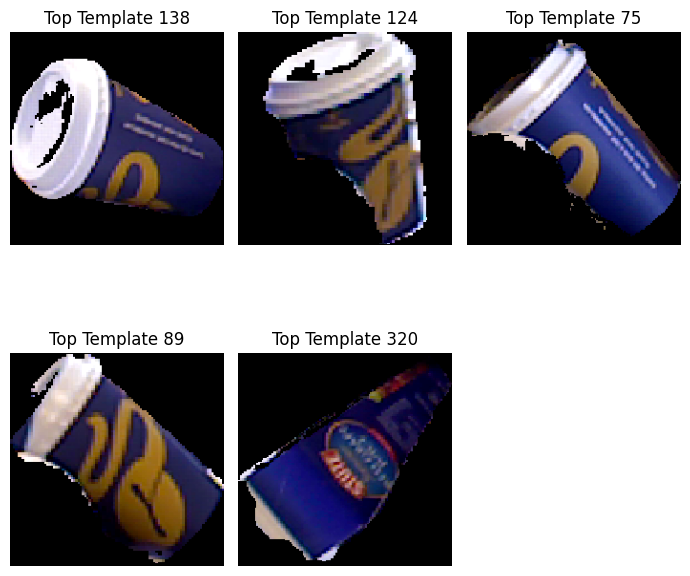

Top 5 scores: [0.481, 0.432, 0.35, 0.321, 0.284]
Average score: 0.374


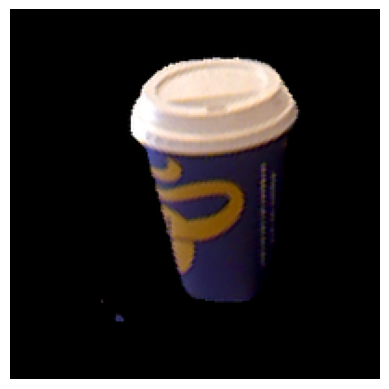

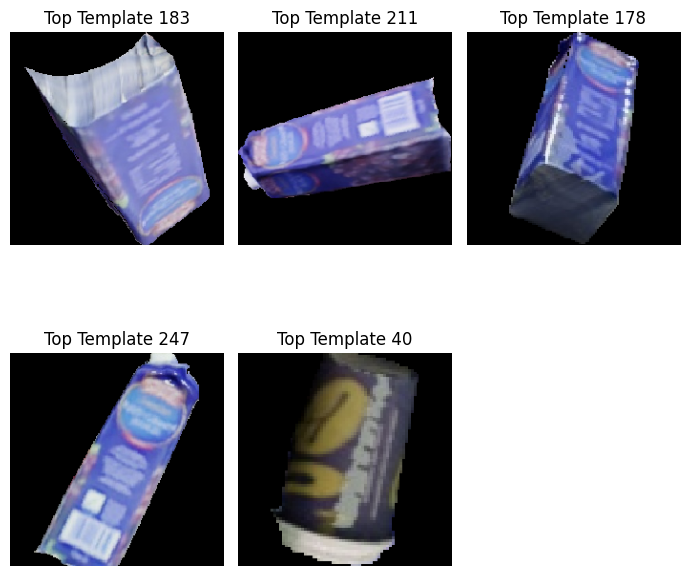

Top 5 scores: [0.439, 0.375, 0.359, 0.344, 0.33]
Average score: 0.37


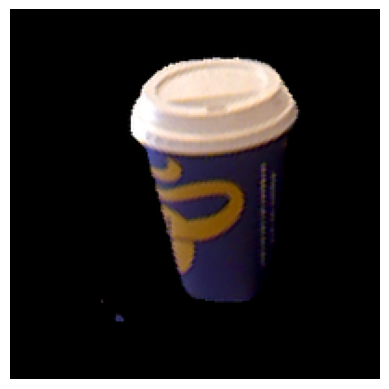

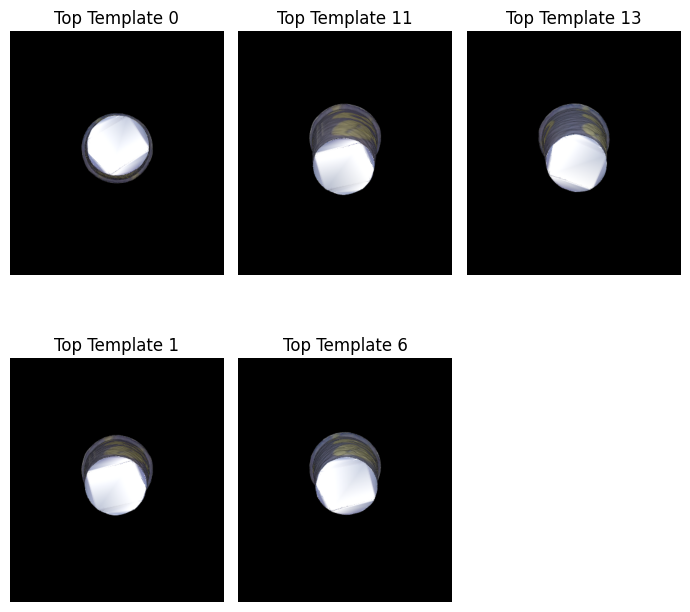

Top 5 scores: [0.511, 0.502, 0.496, 0.495, 0.49]
Average score: 0.499


tensor([[0.0166]])

In [ ]:
# Rotate 45 
rotated_45_features = cnos_crop_feature_extraction(img_45, dinov2_vitl14, device)
calculate_similarity(full_img_45, rotated_45_features, real_ref_features, real_templates)
calculate_similarity(full_img_45, rotated_45_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_45, rotated_45_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
rotated_45_scores = metric(normal_features[:, None, :], rotated_45_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
rotated_45_scores

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


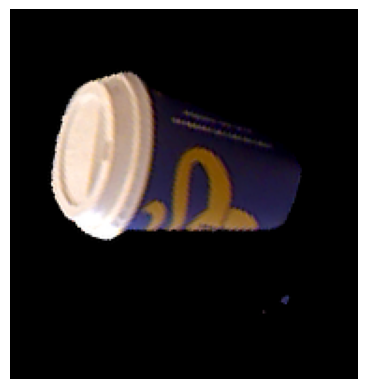

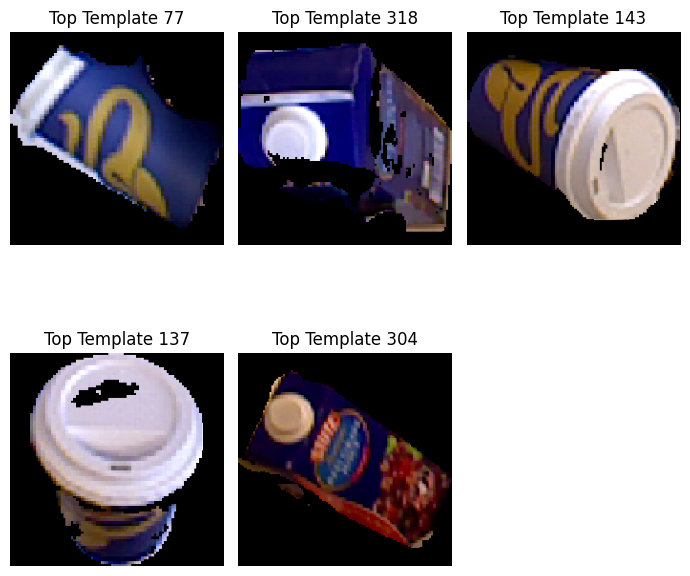

Top 5 scores: [0.837, 0.82, 0.733, 0.698, 0.682]
Average score: 0.754


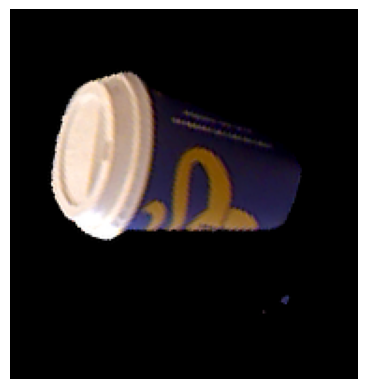

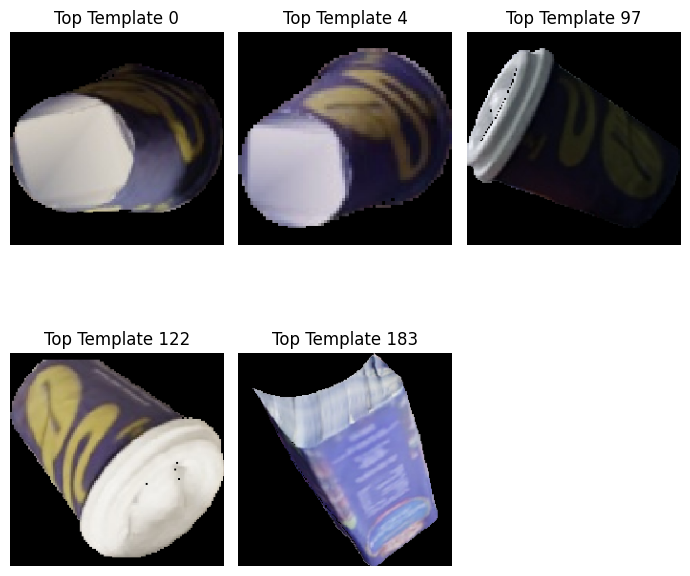

Top 5 scores: [0.596, 0.539, 0.492, 0.474, 0.435]
Average score: 0.507


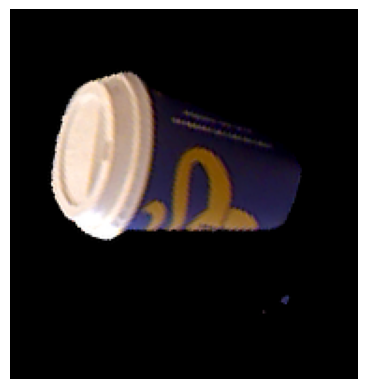

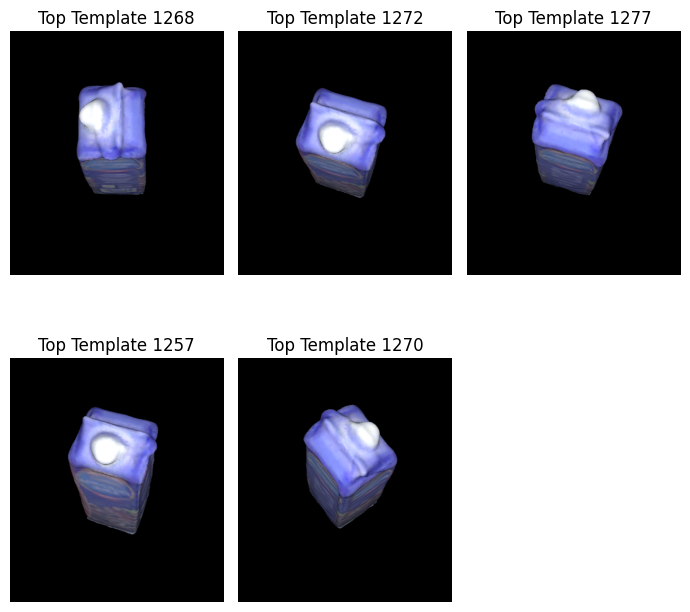

Top 5 scores: [0.841, 0.81, 0.792, 0.77, 0.754]
Average score: 0.794


tensor([[0.3181]])

In [ ]:
# Rotate 120
img_120 = ndimage.rotate(img, 120, reshape=False)
full_img_120 = ndimage.rotate(img, 120, reshape=True)
# Rotate 120
rotated_120_features = cnos_crop_feature_extraction(full_img_120, dinov2_vitl14, device)
calculate_similarity(full_img_120, rotated_120_features, real_ref_features, real_templates)
calculate_similarity(full_img_120, rotated_120_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_120, rotated_120_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_120_crop
rotated_120_scores = metric(normal_features[:, None, :], rotated_120_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
rotated_120_scores


## 3.4 Occluded crop

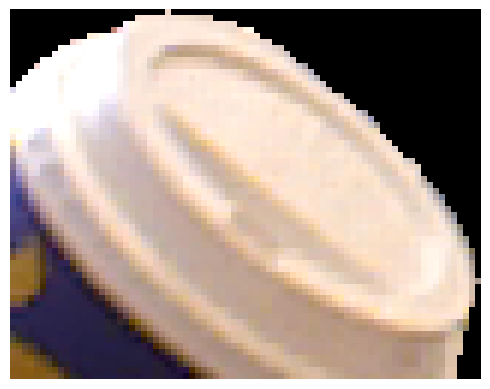

In [ ]:
# occluded_crop = crop_rgb[124//2:,:157//2,:]
occluded_crop = crop_rgb[:124//2,157//2:,:]
import matplotlib.pyplot as plt
plt.imshow(occluded_crop)
plt.axis("off")
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


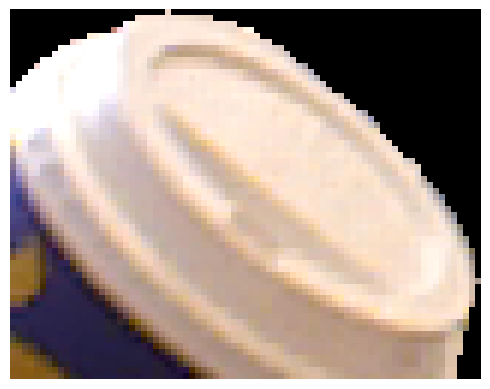

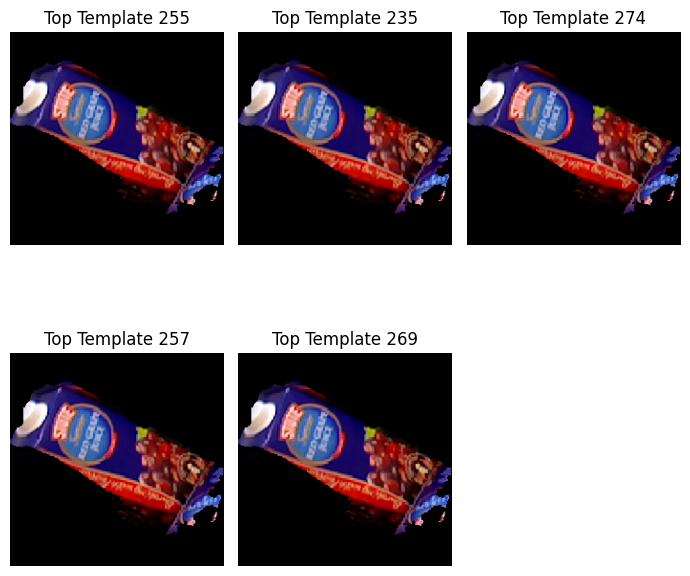

Top 5 scores: [0.92, 0.92, 0.92, 0.92, 0.92]
Average score: 0.92


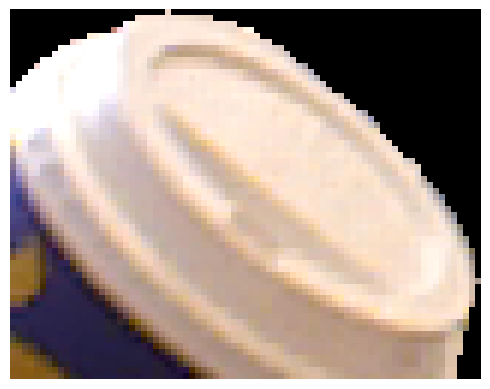

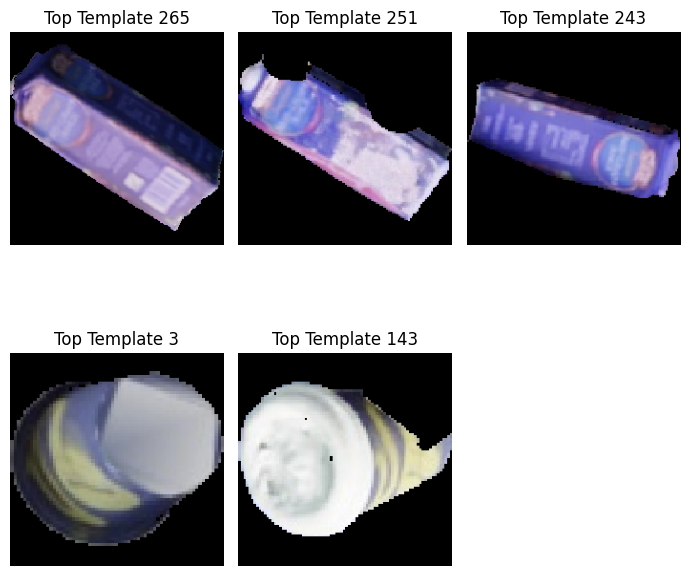

Top 5 scores: [0.889, 0.88, 0.859, 0.852, 0.849]
Average score: 0.866


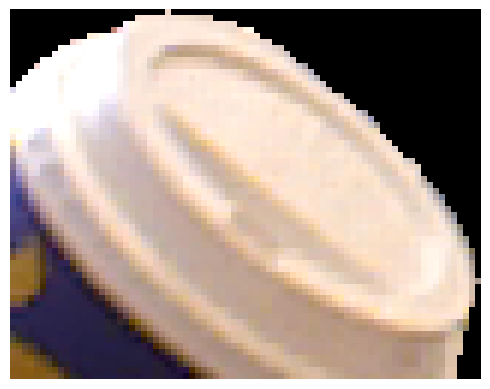

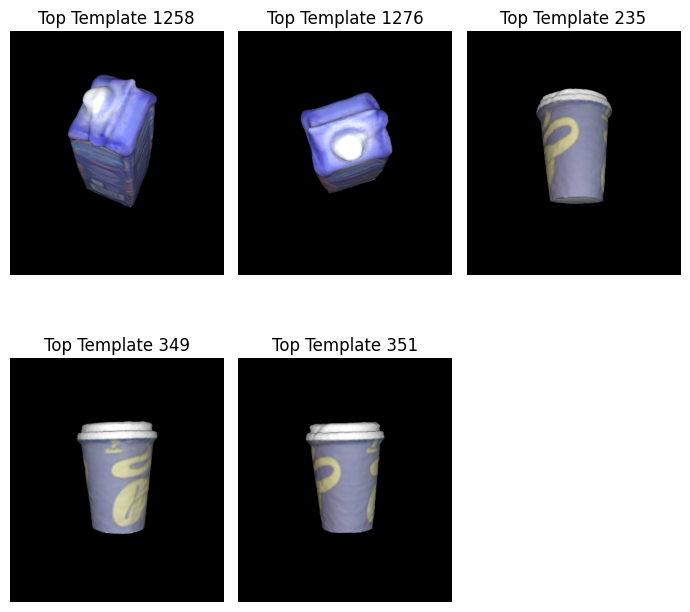

Top 5 scores: [0.678, 0.532, 0.528, 0.518, 0.518]
Average score: 0.555


tensor([[0.]])

In [ ]:
occluded_features = cnos_crop_feature_extraction(occluded_crop, dinov2_vitl14, device)
# Real templates
calculate_similarity(occluded_crop, occluded_features, real_ref_features, real_templates)
calculate_similarity(occluded_crop, occluded_features, syn_ref_features, syn_templates)
calculate_similarity(occluded_crop, occluded_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
occluded_scores = metric(normal_features[:, None, :], occluded_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
occluded_scores

In [ ]:
900,1024

(900, 1024)

## 3.5 Small crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


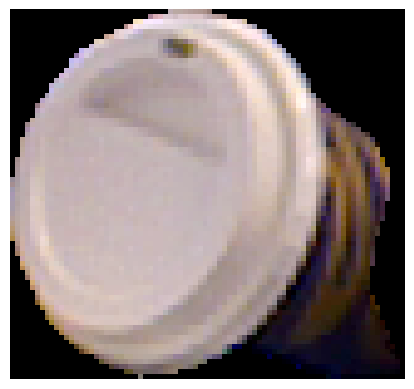

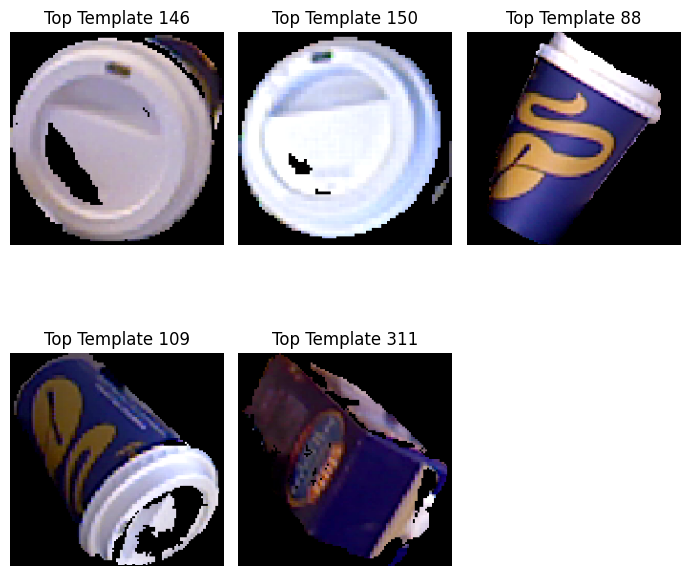

Top 5 scores: [0.924, 0.873, 0.872, 0.868, 0.867]
Average score: 0.881


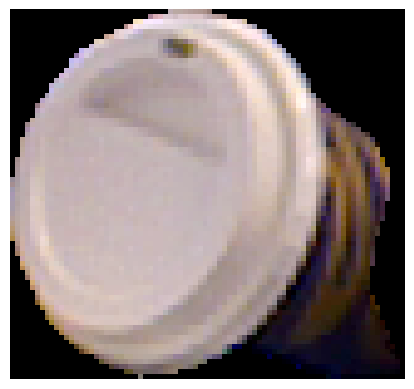

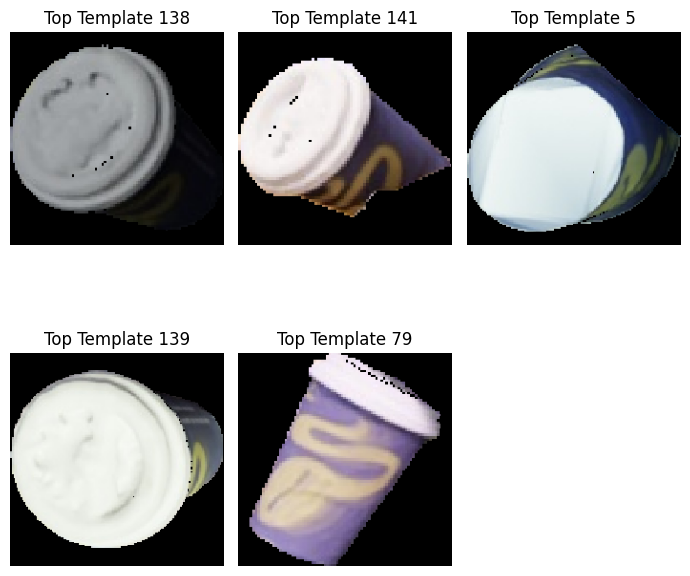

Top 5 scores: [0.936, 0.903, 0.878, 0.858, 0.849]
Average score: 0.885


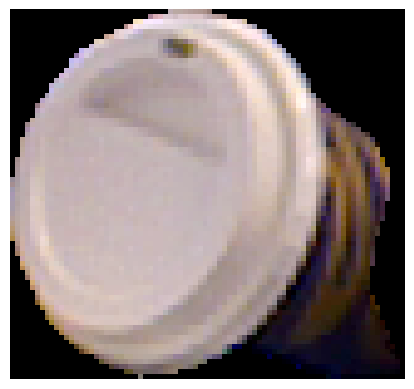

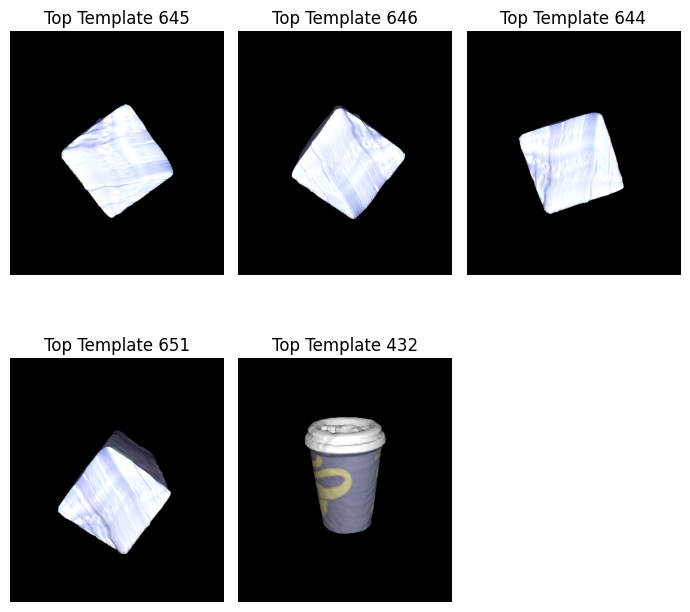

Top 5 scores: [0.846, 0.845, 0.845, 0.827, 0.827]
Average score: 0.838


In [ ]:
# Small crop
small_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop2.png").convert("RGB")) # (124, 157, 3)
# normal crop
small_features = cnos_crop_feature_extraction(small_crop_rgb, dinov2_vitl14, device)
calculate_similarity(small_crop_rgb, small_features, real_ref_features, real_templates)
calculate_similarity(small_crop_rgb, small_features, syn_ref_features, syn_templates)
calculate_similarity(small_crop_rgb, small_features, pyrender_ref_features, pyrender_templates)

In [ ]:
1, 1024
162, 1024

(162, 1024)

In [ ]:
30,30,1024

(30, 30, 1024)

## 3.6 Background Crop

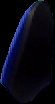

In [ ]:
crop1["crop"]

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


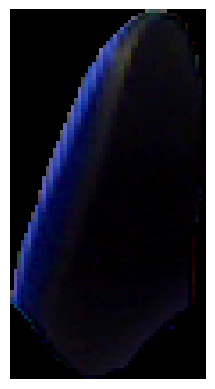

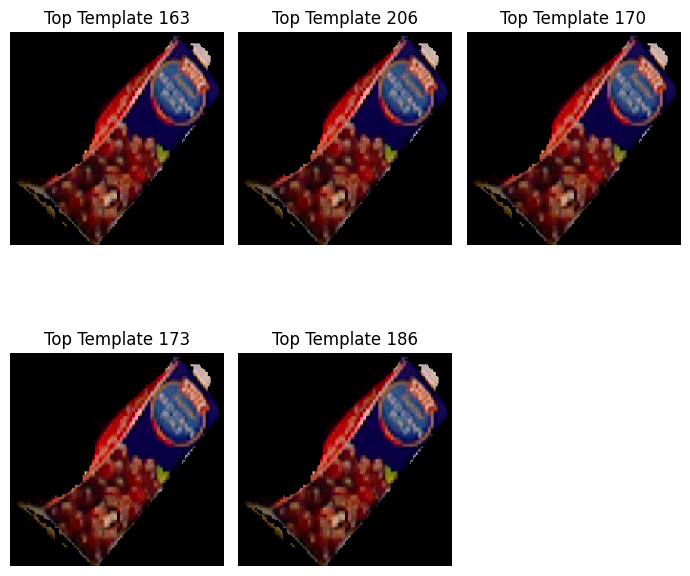

Top 5 scores: [0.547, 0.547, 0.547, 0.547, 0.547]
Average score: 0.547


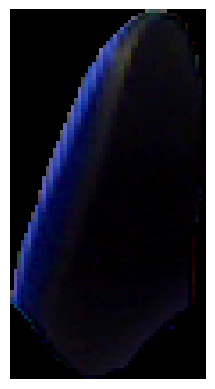

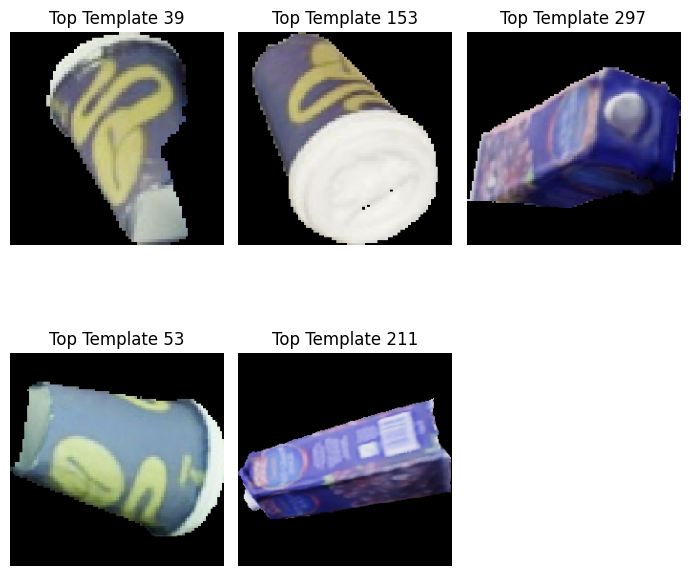

Top 5 scores: [0.795, 0.757, 0.691, 0.609, 0.589]
Average score: 0.688


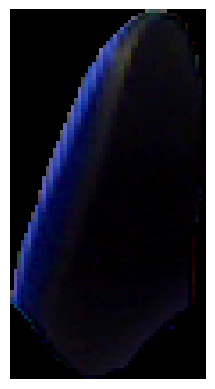

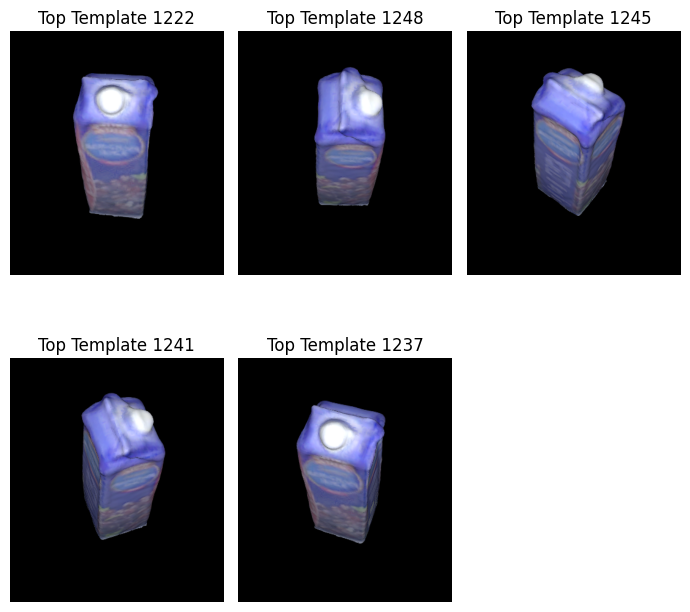

Top 5 scores: [0.475, 0.457, 0.421, 0.414, 0.41]
Average score: 0.435


In [ ]:
background_crop = np.array(crop1["crop"]) # (124, 157, 3)
background_features = cnos_crop_feature_extraction(background_crop, dinov2_vitl14, device)
calculate_similarity(background_crop, background_features, real_ref_features, real_templates)
calculate_similarity(background_crop, background_features, syn_ref_features, syn_templates)
calculate_similarity(background_crop, background_features, pyrender_ref_features, pyrender_templates)

In [ ]:
900*1024


921600

# 4. Final Results

In [ ]:
proposals = [np.array(masked_image) for i, masked_image in enumerate(masked_images)]
proposals_features = torch.cat([cnos_crop_feature_extraction(proposal, dinov2_vitl14, device) for proposal in proposals], dim = 0)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_

In [ ]:
proposals_features.shape

torch.Size([151, 2700])

In [ ]:
import os, sys
import shutil
from tqdm import tqdm
import time
from PIL import Image
import logging
import os, sys
import os.path as osp
from hydra import initialize, compose
# set level logging
logging.basicConfig(level=logging.INFO)
import logging
import numpy as np
from hydra.utils import instantiate
import argparse
import glob
from src.utils.bbox_utils import CropResizePad
from omegaconf import DictConfig, OmegaConf
from torchvision.utils import save_image
import torchvision.transforms as T
from src.model.utils import Detections, convert_npz_to_json
from src.model.loss import Similarity
from src.utils.inout import save_json_bop23
import cv2
import distinctipy
from skimage.feature import canny
from skimage.morphology import binary_dilation
from segment_anything.utils.amg import rle_to_mask

def visualize(rgb, detections, save_path="./tmp/tmp.png"):
    img = rgb.copy()
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    # img = (255*img).astype(np.uint8)
    colors = distinctipy.get_colors(len(detections))
    alpha = 0.33

    for mask_idx, det in enumerate(detections):
        mask = rle_to_mask(det["segmentation"])
        edge = canny(mask)
        edge = binary_dilation(edge, np.ones((2, 2)))
        obj_id = det["category_id"]
        temp_id = obj_id - 1

        r = int(255*colors[temp_id][0])
        g = int(255*colors[temp_id][1])
        b = int(255*colors[temp_id][2])
        img[mask, 0] = alpha*r + (1 - alpha)*img[mask, 0]
        img[mask, 1] = alpha*g + (1 - alpha)*img[mask, 1]
        img[mask, 2] = alpha*b + (1 - alpha)*img[mask, 2]   
        img[edge, :] = 255
    
    out_path = save_path + "/tmp.png"
    img = Image.fromarray(np.uint8(img))
    img.save(out_path)
    prediction = Image.open(out_path)
    
    # concat side by side in PIL
    img = np.array(img)
    concat = Image.new('RGB', (img.shape[1] + prediction.size[0], img.shape[0]))
    concat.paste(rgb, (0, 0))
    concat.paste(prediction, (img.shape[1], 0))
    return concat
        
def modified_run_inference(template_dir, rgb_path, detections, ref_feats, decriptors, num_max_dets = 20, conf_threshold = 0.5, stability_score_thresh = 0.97):

    detections = Detections(detections)
    # decriptors = model.descriptor_model.forward(np.array(rgb), detections)
    
    # get scores per proposal
    scores = metric(decriptors[:, None, :], ref_feats[None, :, :])
    score_per_detection = torch.topk(scores, k=1, dim=-1)[0]
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    )
    
    # get top-k detections
    scores, index = torch.topk(score_per_detection, k=num_max_dets, dim=-1)
    detections.filter(index)
    
    # keep only detections with score > conf_threshold
    detections.filter(scores>conf_threshold)
    detections.add_attribute("scores", scores)
    detections.add_attribute("object_ids", torch.zeros_like(scores))
        
    detections.to_numpy()

    if "test" in template_dir:  
        templates_type = "test"
    elif "train_pbr" in template_dir:
        templates_type = "train_pbr"
    elif "pyrender" in template_dir:
        templates_type = "pyrender"

    save_path = f"output_cnos_analysis_5/{templates_type}/cnos_results/detection"
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    detections.save_to_file(0, 0, 0, save_path, "custom", return_results=False)
    detections = convert_npz_to_json(idx=0, list_npz_paths=[save_path+".npz"])
    save_json_bop23(save_path +".json", detections)
    vis_img = visualize(rgb, detections, save_path)

    plt.figure(figsize=(12, 8))  # width, height in inches
    # Display the image
    plt.imshow(vis_img)
    plt.axis('off')  # Optionally turn off the axis
    plt.show()
    vis_img.save(f"output_cnos_analysis_5/{templates_type}/cnos_results/vis.png")

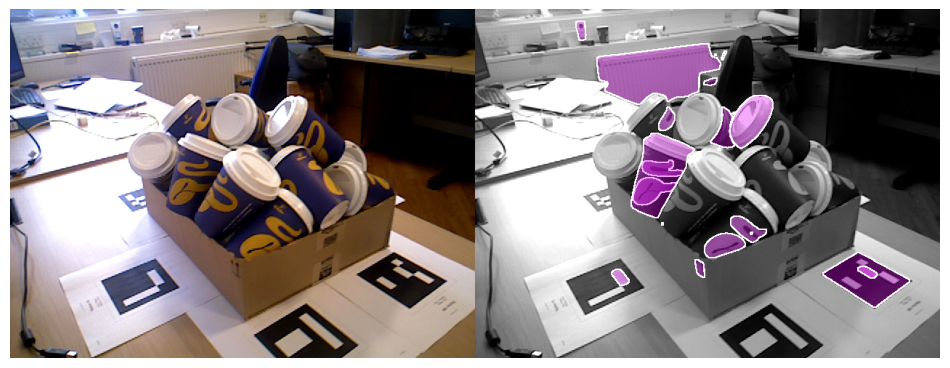

In [ ]:
import os

rgb_path = "cnos_analysis/crop_proposals/000001.png"
template_dir = "foundpose_analysis/icbin/templates/test_images_templates/obj_000001_original"
modified_run_inference(template_dir, rgb_path, detections, real_ref_features, proposals_features, num_max_dets=15)

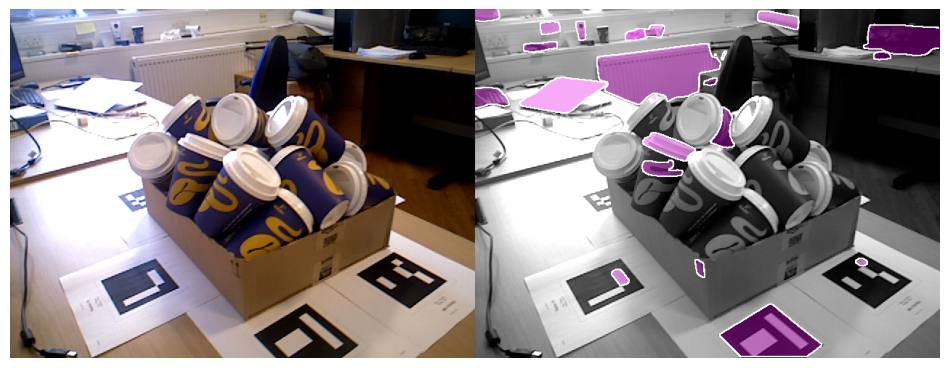

In [ ]:
syn_template_dir = "foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original"
modified_run_inference(syn_template_dir, rgb_path, detections, syn_ref_features, proposals_features)

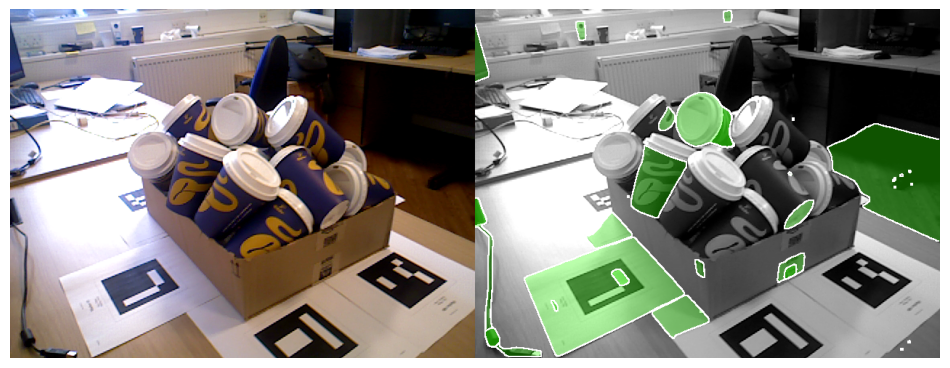

In [ ]:
pyrender_template_dir = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001"
modified_run_inference(pyrender_template_dir, rgb_path, detections, pyrender_ref_features, proposals_features)